In [5]:
!nvidia-smi

Mon Mar 13 14:49:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:05:00.0 Off |                  N/A |
|  0%   48C    P2    87W / 250W |   1292MiB / 11264MiB |     61%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:08:00.0 Off |                  N/A |
|  0%   

In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import configs
import os
from scipy.stats import sem
import matplotlib.cm as cm

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
plt.rcParams['font.family'] = 'sans-serif'

# Testing 4 Room

In [5]:
from deer.environments.FourRoom import MyEnv as Env

In [4]:
x = Env(None, reward=True, size_maze=9)

3


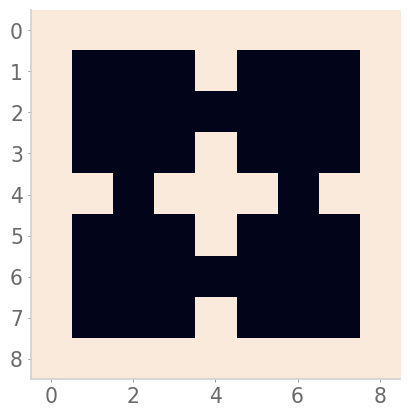

In [5]:
x.create_map(reset_goal=True, quadrant_goal=None)
plt.figure()
plt.imshow(x._map)
print(x._quadrant_goal)
plt.show()

In [107]:
!nvidia-smi

Fri Feb 10 06:31:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:04:00.0 Off |                  N/A |
|  0%   24C    P8     8W / 250W |      1MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:05:00.0 Off |                  N/A |
|  0%   

# Helper functions

In [6]:
def smooth(xs, ys, degree=8):
    poly = np.polyfit(xs, ys, degree)
    poly_y = np.poly1d(poly)(xs)
    return poly_y

def smooth(xs, ys):
    from scipy.signal import lfilter
    n = 5             # larger n gives smoother curves
    b = [1.0 / n] * n  # numerator coefficients
    a = 1              # denominator coefficient
    y_lf = lfilter(b, a, ys)
    return y_lf

def smooth(xs, ys, n=3):
    return np.convolve(ys, np.ones(n)/n, mode='same')

In [7]:
def get_df(pfiles):
    _results = {
        'dimensionality_tracking': [],
        'valid_scores': [], 'valid_steps': [],
        'fname': []
        }
    for pfile in pfiles:
        with open(pfile, 'rb') as f:
            results = pickle.load(f)
        n_fname = len(results['fname'])
        n_scores = len(results['valid_scores'])
        valid_steps_present = 'valid_steps' in results.keys()
        multiple = int(n_fname/n_scores)
        if n_fname % n_scores != 0:
            print('ERROR')
            print(pfile)
        idxs = np.arange(n_scores)
        for idx in idxs:
            _results['dimensionality_tracking'].append(
                results['dimensionality_tracking'][idx])
            _results['valid_scores'].append(
                results['valid_scores'][idx])
            _results['fname'].append(
                results['fname'][idx*multiple])
            if valid_steps_present:
                _results['valid_steps'].append(
                    results['valid_steps'][idx])
            else:
                _results['valid_steps'].append(
                    [0]*len(results['valid_scores'][idx]))
    results = _results

    data = {'scores': [], 'steps': [], 'epochs': [], 'fname': []}
    for idx in range(len(results['valid_scores'])):
        valid_score = results['valid_scores'][idx]
        valid_step = results['valid_steps'][idx]
        fname = results['fname'][idx]
        if fname.endswith('mb_only'):
            fname = 'MB only'
        elif 'mb' in fname:
            fname = 'MB + Entropy'
        elif 'mf' in fname:
            fname = 'None'
        elif 'entro' in fname:
            fname = 'Entropy'
        elif 'clean' in fname:
            fname = 'Random'
        elif '_sr_' in fname:
            fname = f'SR $\gamma={fname[-3:]}$'
        for epoch in range(len(valid_score)):
            data['scores'].append(valid_score[epoch])
            data['epochs'].append(epoch)
            data['fname'].append(fname)
            data['steps'].append(valid_step[epoch])
    df = pd.DataFrame(data)
    return df

# Foraging

In [41]:
engram_dir = '/mnt/smb/locker/aronov-locker/Ching/rl/'

In [136]:
pfiles = []

pickle_dir = f'{engram_dir}pickles/transfer_srSize_dm_dim18/'
for pfile in os.listdir(pickle_dir):
    pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(pfiles)

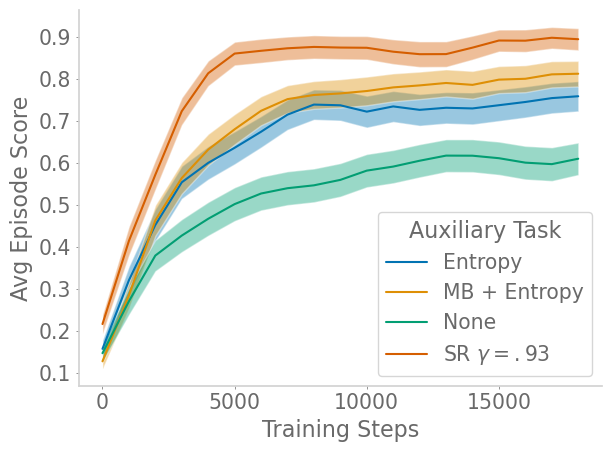

In [137]:
new_df = df.copy()
smooth_line = True
new_df['epochs'] = new_df['epochs']//2*2
epochs = np.unique(new_df['epochs'])
fig, ax = plt.subplots()
for fname_idx, fname in enumerate(
    np.unique(new_df['fname'])
    #['None', 'Entropy', 'MB + Entropy']
    ):
    means = []
    sems = []
    for epoch in epochs:
        vals = new_df[(new_df['fname']==fname) & (new_df['epochs']==epoch)]
        vals = vals['scores']
        means.append(np.mean(vals))
        sems.append(sem(vals))
    means = np.array(means)
    sems = np.array(sems)
    mean_lowerbound = means - sems
    mean_upperbound = means + sems
    if smooth_line:
        means = smooth(epochs, means, 3)
        mean_lowerbound = smooth(epochs, mean_lowerbound)
        mean_upperbound = smooth(epochs, mean_upperbound)
    ax.plot(epochs[:-1]*500, means[:-1], label=fname)
    ax.fill_between(epochs[:-1]*500, mean_lowerbound[:-1], mean_upperbound[:-1], alpha=0.4)
plt.ylabel('Avg Episode Score')
plt.xlabel('Training Steps')
plt.xticks([0, 5000, 10000, 15000])
plt.legend(title='Auxiliary Task')
plt.tight_layout()
plt.savefig('foraging.png', dpi=300)
plt.show()

# Foraging Transfer

In [70]:
engram_dir = '/mnt/smb/locker/aronov-locker/Ching/rl/'

In [82]:
pfiles = []

pickle_dir = f'{engram_dir}pickles/transfer_sr_dm_dim26/'
for pfile in os.listdir(pickle_dir):
    pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(pfiles)

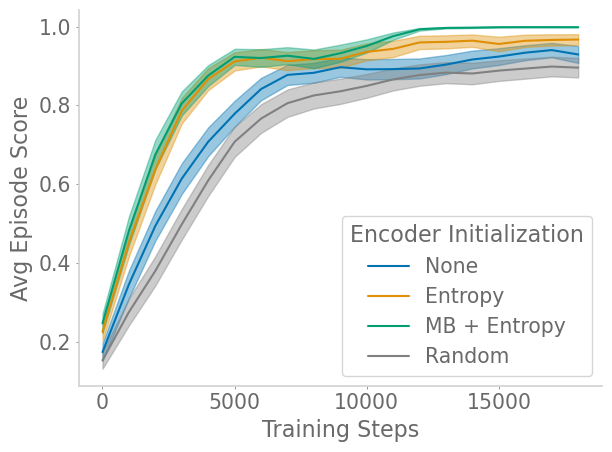

In [87]:
new_df = df.copy()
smooth_line = True
new_df['epochs'] = new_df['epochs']//2*2
epochs = np.unique(new_df['epochs'])
fig, ax = plt.subplots()
colors = ['C0', 'C1', 'C2', 'gray']
for fname_idx, fname in enumerate(
    ['None', 'Entropy', 'MB + Entropy', 'Random']
    ):
    means = []
    sems = []
    for epoch in epochs:
        vals = new_df[(new_df['fname']==fname) & (new_df['epochs']==epoch)]
        vals = vals['scores']
        means.append(np.mean(vals))
        sems.append(sem(vals))
    means = np.array(means)
    sems = np.array(sems)
    mean_lowerbound = means - sems
    mean_upperbound = means + sems
    if smooth_line:
        means = smooth(epochs, means, 3)
        mean_lowerbound = smooth(epochs, mean_lowerbound)
        mean_upperbound = smooth(epochs, mean_upperbound)
    ax.plot(epochs[:-1]*500, means[:-1], label=fname, color=colors[fname_idx])
    ax.fill_between(
        epochs[:-1]*500, mean_lowerbound[:-1], mean_upperbound[:-1],
        alpha=0.4, color=colors[fname_idx])
plt.ylabel('Avg Episode Score')
plt.xlabel('Training Steps')
plt.xticks([0, 5000, 10000, 15000])
plt.legend(title='Encoder Initialization')
plt.tight_layout()
plt.savefig('foraging_transfer.png', dpi=300)
plt.show()

# SR Foraging

In [2]:
engram_dir = '/mnt/smb/locker/aronov-locker/Ching/rl/'

In [96]:
pfiles = []

pickle_dir = f'{engram_dir}pickles/transfer_srSize_dm_dim28/'
for pfile in os.listdir(pickle_dir):
    pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(pfiles)

In [97]:
np.unique(df['fname'])

array(['Entropy', 'None', 'SR $\\gamma=.93$'], dtype=object)

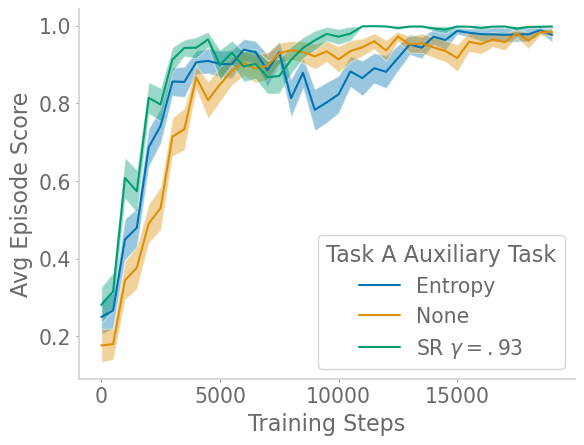

In [98]:
new_df = df.copy()
smooth_line = False
#new_df['epochs'] = new_df['epochs']//2*2
epochs = np.unique(new_df['epochs'])
fig, ax = plt.subplots()
colors = ['C2', 'darkgreen']
for fname_idx, fname in enumerate(
    np.unique(new_df['fname'])
    #['MB + Entropy', 'SR $\gamma=0.9$']
    ):
    means = []
    sems = []
    for epoch in epochs:
        vals = new_df[(new_df['fname']==fname) & (new_df['epochs']==epoch)]
        vals = vals['scores']
        means.append(np.mean(vals))
        sems.append(sem(vals))
    means = np.array(means)
    sems = np.array(sems)
    mean_lowerbound = means - sems
    mean_upperbound = means + sems
    if smooth_line:
        means = smooth(epochs, means, 3)
        mean_lowerbound = smooth(epochs, mean_lowerbound)
        mean_upperbound = smooth(epochs, mean_upperbound)
    ax.plot(epochs[:-1]*500, means[:-1], label=fname)#, color=colors[fname_idx])
    ax.fill_between(
        epochs[:-1]*500, mean_lowerbound[:-1], mean_upperbound[:-1],
        alpha=0.4)#, color=colors[fname_idx])
plt.ylabel('Avg Episode Score')
plt.xlabel('Training Steps')
plt.legend(title='Task A Auxiliary Task')
plt.show()

# SR Foraging Transfer

In [95]:
engram_dir = '/mnt/smb/locker/aronov-locker/Ching/rl/'

In [34]:
pfiles = []

pickle_dir = f'{engram_dir}pickles/transfer_sr_dm_dim26/'
for pfile in os.listdir(pickle_dir):
    pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(pfiles)

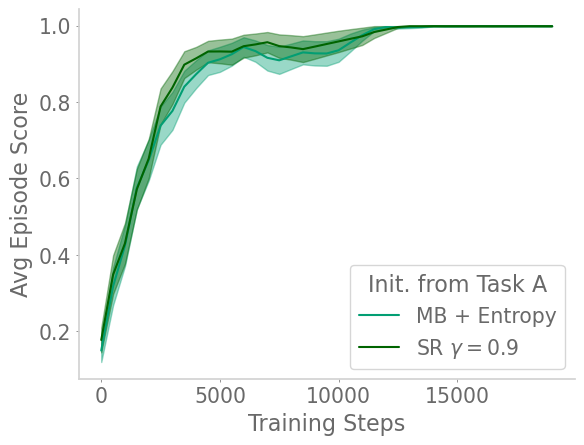

In [40]:
new_df = df.copy()
smooth_line = True
#new_df['epochs'] = new_df['epochs']//2*2
epochs = np.unique(new_df['epochs'])
fig, ax = plt.subplots()
colors = ['C2', 'darkgreen']
for fname_idx, fname in enumerate([
    'MB + Entropy', 'SR $\gamma=0.9$'
    ]):
    means = []
    sems = []
    for epoch in epochs:
        vals = new_df[(new_df['fname']==fname) & (new_df['epochs']==epoch)]
        vals = vals['scores']
        means.append(np.mean(vals))
        sems.append(sem(vals))
    means = np.array(means)
    sems = np.array(sems)
    mean_lowerbound = means - sems
    mean_upperbound = means + sems
    if smooth_line:
        means = smooth(epochs, means, 3)
        mean_lowerbound = smooth(epochs, mean_lowerbound)
        mean_upperbound = smooth(epochs, mean_upperbound)
    ax.plot(epochs[:-1]*500, means[:-1], label=fname, color=colors[fname_idx])
    ax.fill_between(
        epochs[:-1]*500, mean_lowerbound[:-1], mean_upperbound[:-1],
        alpha=0.4, color=colors[fname_idx])
plt.ylabel('Avg Episode Score')
plt.xlabel('Training Steps')
plt.legend(title='Init. from Task A')
plt.show()

# Foraging Transfer

In [99]:
engram_dir = '/mnt/smb/locker/aronov-locker/Ching/rl/'

In [128]:
pfiles = []

pickle_dir = f'{engram_dir}pickles/transfer_srSize_dm_dim24/'
for pfile in os.listdir(pickle_dir):
    pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(pfiles)

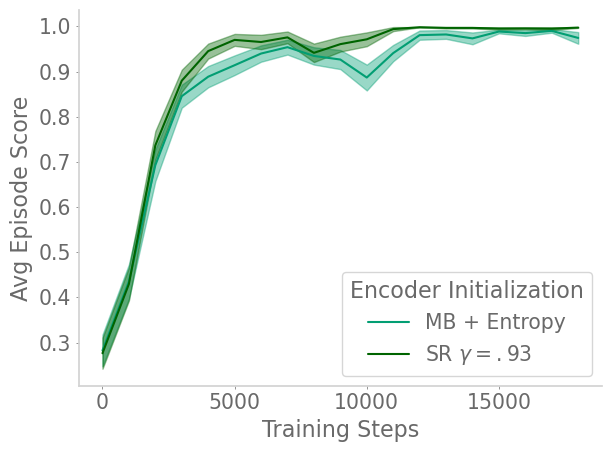

In [133]:
new_df = df.copy()
smooth_line = False
new_df['epochs'] = new_df['epochs']//2*2
epochs = np.unique(new_df['epochs'])
fig, ax = plt.subplots()
colors = ['C2', 'darkgreen']
for fname_idx, fname in enumerate(
    #np.unique(new_df['fname'])
    ['MB + Entropy', 'SR $\gamma=.93$']
    ):
    means = []
    sems = []
    for epoch in epochs:
        vals = new_df[(new_df['fname']==fname) & (new_df['epochs']==epoch)]
        vals = vals['scores']
        means.append(np.mean(vals))
        sems.append(sem(vals))
    means = np.array(means)
    sems = np.array(sems)
    mean_lowerbound = means - sems
    mean_upperbound = means + sems
    if smooth_line:
        means = smooth(epochs, means, 3)
        mean_lowerbound = smooth(epochs, mean_lowerbound)
        mean_upperbound = smooth(epochs, mean_upperbound)
    ax.plot(epochs[:-1]*500, means[:-1], label=fname, color=colors[fname_idx])
    ax.fill_between(
        epochs[:-1]*500, mean_lowerbound[:-1], mean_upperbound[:-1],
        alpha=0.4, color=colors[fname_idx])
plt.ylabel('Avg Episode Score')
plt.xlabel('Training Steps')
plt.xticks([0, 5000, 10000, 15000])
plt.legend(title='Encoder Initialization')
plt.tight_layout()
plt.savefig('sr_foraging_transfer.png', dpi=300)
plt.show()

In [66]:
from scipy.special import rel_entr

In [107]:
pickle_dir = '/mnt/smb/locker/aronov-locker/Ching/rl/pickles/foraging_simplest_dim9/'
pfiles = []
for pfile in os.listdir(pickle_dir):
    pfiles.append(f'{pickle_dir}{pfile}')

_results = {
    'dimensionality_tracking': [],
    'dimensionality_kl': [],
    'var_2d': [],
    'fname': []
    }
for pfile in pfiles:
    with open(pfile, 'rb') as f:
        results = pickle.load(f)
    n_fname = len(results['fname'])
    n_scores = len(results['valid_scores'])
    multiple = int(n_fname/n_scores)
    if n_fname % n_scores != 0:
        print('ERROR')
        print(pfile)
    idxs = np.arange(n_scores)
    for idx in idxs:
        var_ratio = results['dimensionality_variance_ratio'][idx]
        n_components = len(var_ratio)
        kl = sum(rel_entr(np.ones(n_components)/n_components, var_ratio))
        _results['dimensionality_tracking'].append(
            results['dimensionality_tracking'][idx])
        _results['dimensionality_kl'].append(kl)
        _results['var_2d'].append(np.sum(var_ratio[:2]))
        fname = results['fname'][idx*multiple]
        if 'mb_only' in fname:
            fname = 'MB only'
        elif 'mb' in fname:
            fname = 'MB'
        elif 'mf' in fname:
            fname = 'MF'
        elif 'entro' in fname:
            fname = 'Entro'
        elif 'clean' in fname:
            fname = 'Random'
        _results['fname'].append(fname)
for key in _results.keys():
    _results[key] = np.array(_results[key])
results = _results

In [108]:
df = pd.DataFrame(results)

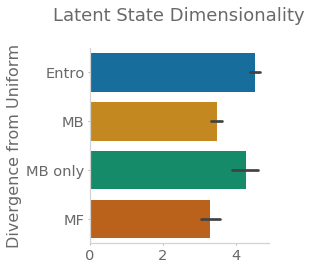

In [109]:
plt.figure(figsize=(6.4*0.5, 4.8*0.75))
sns.barplot(
    y='fname', x='dimensionality_kl', data=df,
    hue_order=['Random', 'MF', 'MB only', 'Entro', 'MB']
    )
plt.ylabel('Divergence from Uniform')
plt.xlabel('')
plt.title('Latent State Dimensionality\n', fontsize=18)
#plt.xticks([0, 1, 2], ['MF', 'MF + S', 'MF + S + MB'], rotation=30)
plt.show()

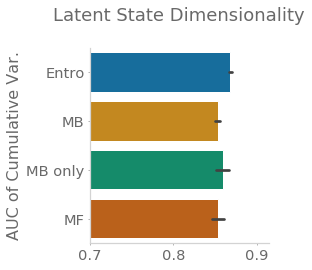

In [110]:
plt.figure(figsize=(6.4*0.5, 4.8*0.75))
sns.barplot(
    y='fname', x='dimensionality_tracking', data=df,
    hue_order=['Random', 'MF', 'MB only', 'Entro', 'MB']
    )
plt.ylabel('AUC of Cumulative Var.')
plt.xlabel('')
plt.title('Latent State Dimensionality\n', fontsize=18)
plt.xlim(left=0.7)
#plt.xticks([0, 1, 2], ['MF', 'MF + S', 'MF + S + MB'], rotation=30)
plt.show()

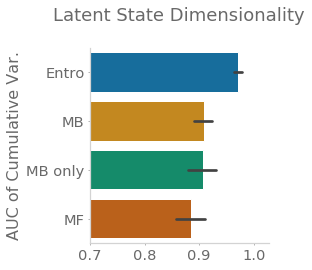

In [114]:
plt.figure(figsize=(6.4*0.5, 4.8*0.75))
sns.barplot(
    y='fname', x='var_2d', data=df,
    hue_order=['Random', 'MF', 'MB only', 'Entro', 'MB']
    )
plt.ylabel('AUC of Cumulative Var.')
plt.xlabel('')
plt.title('Latent State Dimensionality\n', fontsize=18)
plt.xlim(left=0.7)
#plt.xticks([0, 1, 2], ['MF', 'MF + S', 'MF + S + MB'], rotation=30)
plt.show()